# **Image Classification Model Deployment**
## **Reynara Ezra Pratama**

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
!pip install ipython-autotime
%load_ext autotime

time: 151 µs (started: 2021-07-05 05:55:57 +00:00)


# **Get Data**

In [3]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2021-07-05 05:55:57--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  8.71MB/s    in 55s     

2021-07-05 05:56:53 (5.56 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]

time: 56.5 s (started: 2021-07-05 05:55:57 +00:00)


# **Extract Data**

In [4]:
import zipfile, os

local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

time: 3.79 s (started: 2021-07-05 05:56:53 +00:00)


# **Check Data**

In [5]:
print('Number of Rock Images :{}'.format(len(os.listdir('/tmp/rockpaperscissors/rock/'))))
print('Number of Paper Images :{}'.format(len(os.listdir('/tmp/rockpaperscissors/paper/'))))
print('Number of Scissors Images :{}'.format(len(os.listdir('/tmp/rockpaperscissors/scissors/'))))
print('Total Images : {}'.format(
    len(os.listdir('/tmp/rockpaperscissors/rock/')) + 
    len(os.listdir('/tmp/rockpaperscissors/paper/')) + 
    len(os.listdir('/tmp/rockpaperscissors/scissors/'))
    )
)

Number of Rock Images :726
Number of Paper Images :712
Number of Scissors Images :750
Total Images : 2188
time: 10 ms (started: 2021-07-05 05:56:57 +00:00)


# **Split Folder**

In [6]:
!pip install split_folders

import splitfolders

splitfolders.ratio('/tmp/rockpaperscissors/rps-cv-images', '/tmp/rockpaperscissors/data', seed=1, ratio=(0.8, 0.2))

Copying files: 2188 files [00:00, 4394.80 files/s]

time: 3.38 s (started: 2021-07-05 05:56:57 +00:00)


In [7]:
base_dir = '/tmp/rockpaperscissors/data'
train_dir = os.path.join(base_dir, 'train') ## Train Dataset
validation_dir = os.path.join(base_dir, 'val') ## Validation Dataset

time: 2.49 ms (started: 2021-07-05 05:57:01 +00:00)


In [8]:
os.listdir('/tmp/rockpaperscissors/data/train')

['rock', 'scissors', 'paper']

time: 4.71 ms (started: 2021-07-05 05:57:01 +00:00)


In [9]:
os.listdir('/tmp/rockpaperscissors/data/val')

['rock', 'scissors', 'paper']

time: 3.8 ms (started: 2021-07-05 05:57:01 +00:00)


In [10]:
train_rock_dir = os.path.join(train_dir, 'rock')
train_paper_dir = os.path.join(train_dir, 'paper')
train_scissors_dir = os.path.join(train_dir, 'scissors')

validation_rock_dir = os.path.join(validation_dir, 'rock')
validation_paper_dir = os.path.join(validation_dir, 'paper')
validation_scissors_dir = os.path.join(validation_dir, 'scissors')

time: 3.95 ms (started: 2021-07-05 05:57:01 +00:00)


# **Check Train and Test**

**Train 80%**

In [11]:
total_size_train = (
    len(os.listdir('/tmp/rockpaperscissors/data/train/rock')) + 
    len(os.listdir('/tmp/rockpaperscissors/data/train/paper')) +
    len(os.listdir('/tmp/rockpaperscissors/data/train/scissors'))
)
print('Total Training Data is : {}'.format(total_size_train))

Total Training Data is : 1749
time: 5.66 ms (started: 2021-07-05 05:57:01 +00:00)


**Test 20%**

In [12]:
total_size_validation = (
    len(os.listdir('/tmp/rockpaperscissors/data/val/rock')) +
    len(os.listdir('/tmp/rockpaperscissors/data/val/paper')) +
    len(os.listdir('/tmp/rockpaperscissors/data/val/scissors'))
)
print('Total Test Data is : {}'.format(total_size_validation))

Total Test Data is : 439
time: 3.69 ms (started: 2021-07-05 05:57:01 +00:00)


# **Image Augmentation**

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.2,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest'
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 128,
    class_mode = 'categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 128,
    class_mode = 'categorical'
)

Found 1749 images belonging to 3 classes.
Found 439 images belonging to 3 classes.
time: 226 ms (started: 2021-07-05 05:57:01 +00:00)


# **Callback**

In [14]:
reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.15,
    patience=5,
    min_lr=2.e-5
)

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

time: 4.39 ms (started: 2021-07-05 05:57:01 +00:00)


# **Construct Model Using CNN**

In [15]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])

time: 5.31 s (started: 2021-07-05 05:57:01 +00:00)


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

# **Run Model**

In [17]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'Adam',
    metrics = ['accuracy']
)

time: 17.2 ms (started: 2021-07-05 05:57:06 +00:00)


In [18]:
history = model.fit(
    train_generator,
    epochs = 100,
    callbacks = [reduce_LR, stop_early],
    validation_data = validation_generator,
    verbose = 1
)

Epoch 1/100
14/14 [==============================] - 45s 886ms/step - loss: 1.1271 - accuracy: 0.4122 - val_loss: 1.0741 - val_accuracy: 0.6469
Epoch 2/100
14/14 [==============================] - 12s 833ms/step - loss: 0.9832 - accuracy: 0.5346 - val_loss: 0.6095 - val_accuracy: 0.8861
Epoch 3/100
14/14 [==============================] - 12s 861ms/step - loss: 0.6309 - accuracy: 0.7587 - val_loss: 0.3110 - val_accuracy: 0.9226
Epoch 4/100
14/14 [==============================] - 12s 825ms/step - loss: 0.4319 - accuracy: 0.8353 - val_loss: 0.1545 - val_accuracy: 0.9704
Epoch 5/100
14/14 [==============================] - 12s 827ms/step - loss: 0.3168 - accuracy: 0.8822 - val_loss: 0.1165 - val_accuracy: 0.9613
Epoch 6/100
14/14 [==============================] - 12s 838ms/step - loss: 0.2839 - accuracy: 0.9034 - val_loss: 0.0910 - val_accuracy: 0.9704
Epoch 7/100
14/14 [==============================] - 12s 823ms/step - loss: 0.3165 - accuracy: 0.8811 - val_loss: 0.1048 - val_accuracy:

# **Plot Model History**

In [19]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
  plt.figure(figsize=(18,5))
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plot_acc = plt.plot(epochs, acc, 'red', label='Training Accuracy')
  plot_val_acc = plt.plot(epochs, val_acc, 'blue', label='Validation Accuracy')
  plt.xlabel('Epoch', fontsize=15)
  plt.ylabel('Accuracy', fontsize=15)
  plt.title('Training and Validation Accuracy', fontsize=25)
  plt.legend(bbox_to_anchor=(1,1), loc='best')
  plt.grid()
  plt.show()

def plot_loss(history):
  plt.figure(figsize=(18,5))
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plot_loss = plt.plot(epochs, loss, 'red', label='Training Loss')
  plot_val_loss = plt.plot(epochs, val_loss, 'blue', label='Validation Loss')
  plt.xlabel('Epoch', fontsize=15)
  plt.ylabel('Loss', fontsize=15)
  plt.title('Training and Validation Loss', fontsize=25)
  plt.legend(bbox_to_anchor=(1,1), loc='best')
  plt.grid()
  plt.show()

time: 9.06 s (started: 2021-07-05 06:06:42 +00:00)


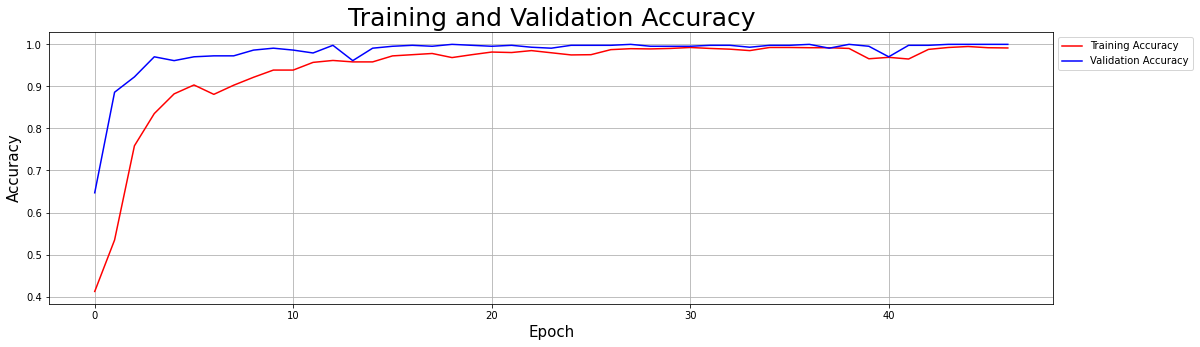

time: 194 ms (started: 2021-07-05 06:06:51 +00:00)


In [20]:
plot_accuracy(history)

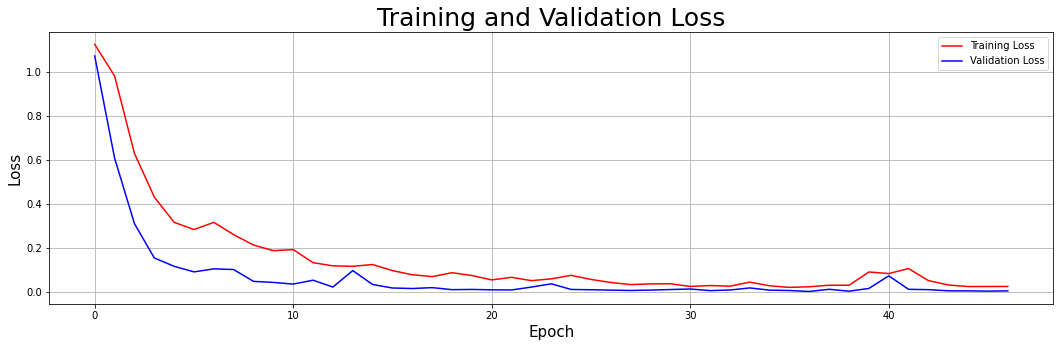

time: 171 ms (started: 2021-07-05 06:06:51 +00:00)


In [21]:
plot_loss(history)

# **Save Model to TFlite**

In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmptzo6caol/assets
time: 1.81 s (started: 2021-07-05 06:06:52 +00:00)
